# 2021-12-13 Improved pass first/second calculations

Results below are for commit: ### (Rerunning the code below for other commits is not likely/guaranteed to give the same results.)

I have now made the improvement suggested in yesterday's notes to `sc_scenario_helper.get_access_order_implications()`, with a more accurate/complete test of whether simply accelerating to free speed will be enough to achieve each access order.

In the runs below we can see that the `oVAoSNv` model is unchanged from yesterday's notes, but that the `oVAoAN` model now behaves much more like one would expect. It still has an overall tendency to slow down, possibly due to the negative acceleration buffer issue also mentioned in yesterday's notes. This is probably a good next thing to look at.

Further below, the "unit tests" from previously show that this model implementation change is causing noticeable changes to model behaviour, so rerunning of deterministic fits will definitely be needed...

In [1]:
# append root folder of repo to PYTHONPATH (https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder)
import sys
from pathlib import Path
parent_path = str(Path('.').absolute().parent)
if not (parent_path in sys.path):
    sys.path.append(parent_path)
    sys.path.append(parent_path + '/SCPaper')
print(sys.path)

# imports needed to run the simulations
import math
import copy
import numpy as np
import commotions
import sc_scenario
import sc_scenario_perception
from sc_scenario_helper import CtrlType
import sc_fitting

N_REPS = 100

for model in ('oVAoSNv', 'oVAoAN'):
    print(f'***** Model {model}:')
    assumptions = sc_scenario.get_assumptions_dict_from_string(model)
    params = copy.deepcopy(sc_fitting.DEFAULT_PARAMS)
    params_k = copy.deepcopy(sc_fitting.get_default_params_k(model))
    params.sigma_V = 0.1
    params.tau_theta = 0.02
    for car_ttca in (-3, 8, 80):
        print(f'\t--- Car initial time to conflict area: {car_ttca} s:')
        scenario = sc_fitting.SCPaperScenario('TestScenario', 
                                        initial_ttcas=(3, car_ttca), 
                                        veh_const_speed=True,
                                        stop_criteria = sc_fitting.IN_CS_STOP,
                                        metric_names = ('ped_av_speed_to_CS',),
                                        time_step = sc_fitting.PROB_SIM_TIME_STEP,
                                        end_time = sc_fitting.PROB_SIM_END_TIME)
        vs = np.zeros(N_REPS)
        for i in range(N_REPS):
            sim = sc_fitting.simulate_scenario(scenario, assumptions, params, params_k)
            metrics = sc_fitting.get_metrics_for_scenario(scenario, sim)
            vs[i] = metrics['TestScenario_ped_av_speed_to_CS']
        mean_v = np.mean(vs)
        ci_radius = 1.96 * np.std(vs)/math.sqrt(N_REPS)
        print(f'\t\tAverage ped_av_speed_to_CS: {mean_v:.3f} m/s\n'
              f'\t\tCI: [{mean_v - ci_radius:.3f}, {mean_v + ci_radius:.3f}] m/s')       


['C:\\GITHUB\\COMMOTIONSFramework\\diary notebooks', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\python39.zip', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\DLLs', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64', '', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\win32', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\win32\\lib', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\Pythonwin', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\tragma\\.ipython', 'C:\\GITHUB\\COMMOTIONSFramework', 'C:\\GITHUB\\COMMOTIONSFramework/SCPaper']
***** Model oVAoSNv:
	--- Car initial time to conflict area: -3 s:
		Average ped_av_speed_to_CS: 1.300 m/s
		CI: [1.300, 1.300] m/s
	--- Car initial time to conflict area: 8 s:
		Average ped_av_speed_to_CS: 1.139 m/s


## Unit tests, reproducing earlier results

### Basics - there are some differences

Just the base model, no interaction. No changes since 2021-11-29b.

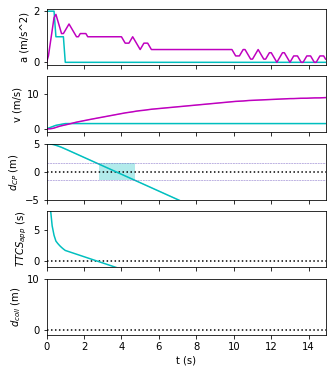

In [2]:
NAMES = ('P', 'V')
WIDTHS = (1.5, 1.5) # setting widths/lengths corresponding to the old default
LENGTHS = (1.5, 1.5) # setting sc_scenario.SHARED_PARAMS.d_C = 1.5
CTRL_TYPES = (CtrlType.SPEED, CtrlType.ACCELERATION) 
INITIAL_POSITIONS = np.array([[0,-5], [400, 0]])
GOALS = np.array([[0, 5], [-50, 0]])
SPEEDS = np.array((0, 0))

optional_assumptions = sc_scenario.get_assumptions_dict(
        default_value = False, oVA = True, oBEo = False, oBEv = False, oAI = False, oEA = False)
sc_simulation = sc_scenario.SCSimulation(
        CTRL_TYPES, WIDTHS, LENGTHS, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = NAMES)
sc_simulation.run()
sc_simulation.do_plots(kinem_states = True)

Baseline kinematics, base model. 

Now I am starting to see some differences from 2021-11-29b.

Initial car distance 30 m:


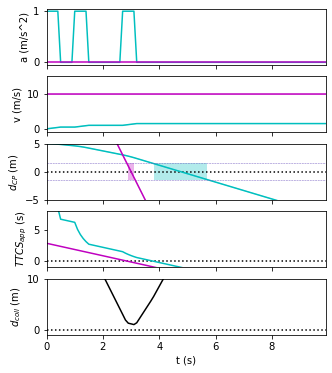

Initial car distance 40 m:


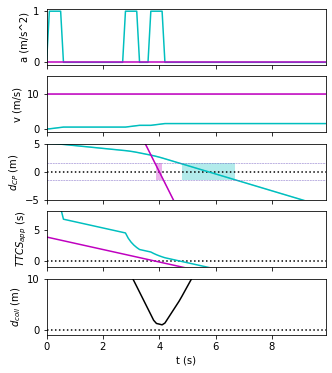

Initial car distance 50 m:


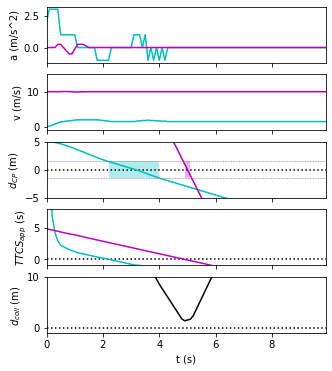

In [3]:
SPEEDS = np.array((0, 10))
PED_Y0 = -5
CONST_ACCS = (None, None)
AFF_VAL_FCN = True
optional_assumptions = sc_scenario.get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN, oBEo = False, oBEv = False, oAI = False, oEA = False)
(params, params_k) = sc_scenario.get_default_params(oVA = AFF_VAL_FCN)


def run_baseline_kinematics(dist0s = (30, 40, 50), 
                            plot_beh_probs = False, plot_beh_activs = False, 
                            plot_beh_accs = False, plot_looming = False, 
                            ped_snaps = None, veh_snaps = None):
    for dist0 in dist0s:
        INITIAL_POSITIONS = np.array([[0, PED_Y0], [dist0, 0]])
        sc_simulation = sc_scenario.SCSimulation(
                CTRL_TYPES, WIDTHS, LENGTHS, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
                end_time = 10, optional_assumptions = optional_assumptions,
                agent_names = NAMES, const_accs = CONST_ACCS, params = params,
                snapshot_times = (ped_snaps, veh_snaps))
        sc_simulation.run()
        print('Initial car distance %d m:' % dist0)
        sc_simulation.do_plots(kinem_states = True, beh_probs = plot_beh_probs,
                              beh_activs = plot_beh_activs, beh_accs = plot_beh_accs,
                              looming = plot_looming)

run_baseline_kinematics()

And here is the same after restoring the pre-safety-margin settings. 

The 30 m simulation seems unchanged, but the other ones, including my trusty, recognisable 40 m simulation look different now.

Initial car distance 30 m:


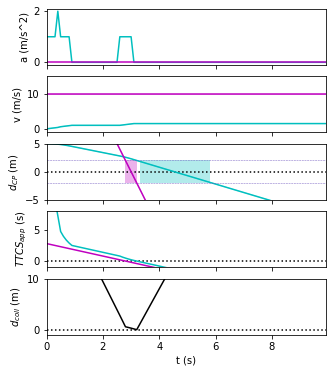

Initial car distance 40 m:


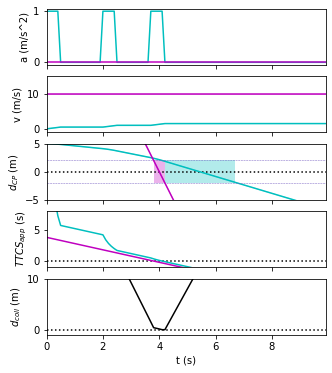

Initial car distance 50 m:


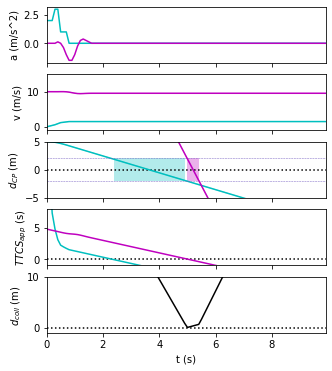

In [4]:
WIDTHS = (2, 2) # setting widths/lengths corresponding to the old default
LENGTHS = (2, 2) # setting sc_scenario.SHARED_PARAMS.d_C = 2
params.T_s = 0
params.D_s = 0
run_baseline_kinematics()

### Testing the `oBEo` etc sequence - also different now

Now there is a noticeable speed up for the `oBEo`-only model, but just a very small one for the one with `oAI`. HArd to tell if this spells big changes or not for the deterministic fitting results...

Turning on oBEo:
Initial car distance 40 m:


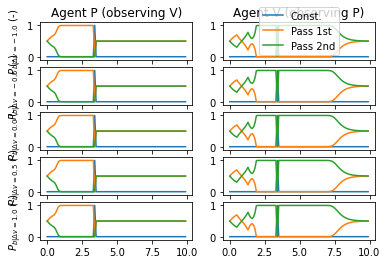

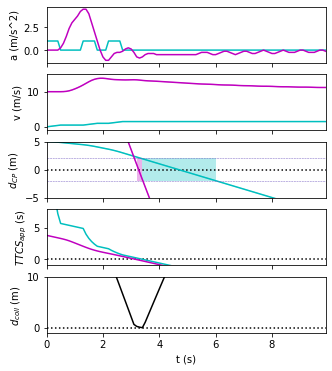

Turning on oBEv:
Initial car distance 40 m:


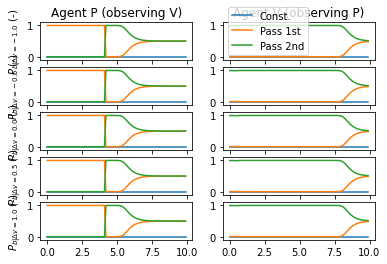

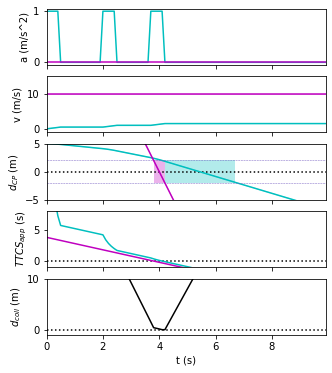

Turning on oAI:
Initial car distance 40 m:


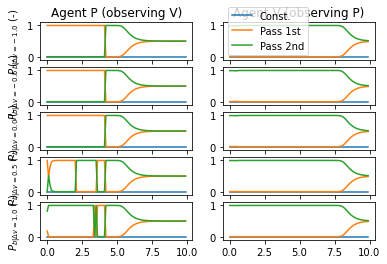

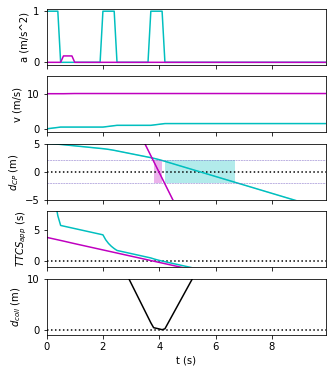

In [5]:
params.T_O1 = 0.1 
params.T_Of = 0.5
params.sigma_O = 0.01
params.beta_V = 160

def run_oBEo_etc_seq():
    global optional_assumptions
    print('Turning on oBEo:')
    optional_assumptions = sc_scenario.get_assumptions_dict(
            default_value = False, oVA = AFF_VAL_FCN, oBEo = True)
    run_baseline_kinematics(dist0s = (40,), plot_beh_probs = True)
    print('Turning on oBEv:')
    optional_assumptions = sc_scenario.get_assumptions_dict(
            default_value = False, oVA = AFF_VAL_FCN, oBEo = True, oBEv = True)
    run_baseline_kinematics(dist0s = (40,), plot_beh_probs = True)
    print('Turning on oAI:')
    optional_assumptions = sc_scenario.get_assumptions_dict(
            default_value = False, oVA = AFF_VAL_FCN, oBEo = True, oBEv = True, oAI = True)
    run_baseline_kinematics(dist0s = (40,), plot_beh_probs = True)
run_oBEo_etc_seq()

And below, just to verify that when I turn off the new access order implication calculations, I get back the old results, familiar from 2021-11-29b and earlier. So it is clearly just these latest modifications that are causing the change in behaviour in these scenarios.

Base model (with old access order implication calculations):
Initial car distance 40 m:


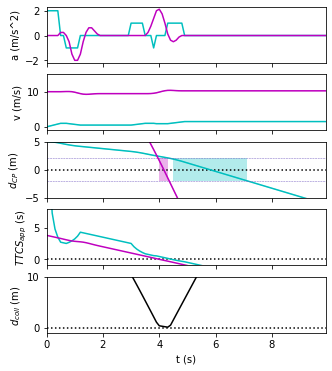

Turning on oBEo:
Initial car distance 40 m:


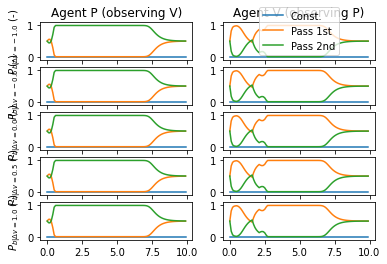

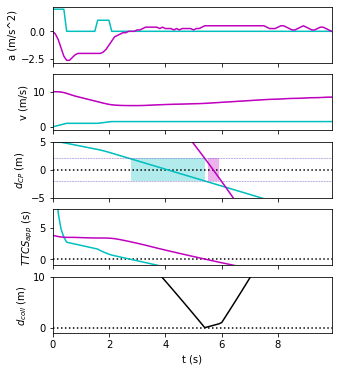

Turning on oBEv:
Initial car distance 40 m:


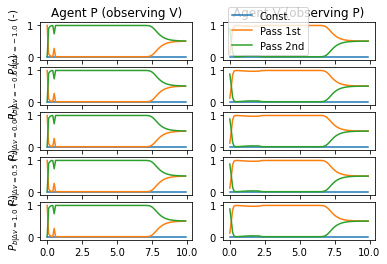

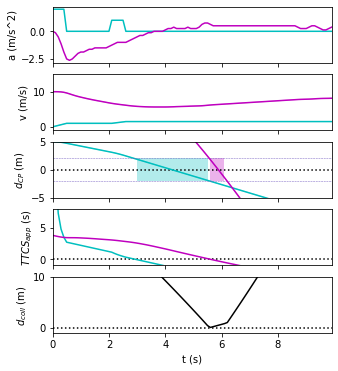

Turning on oAI:
Initial car distance 40 m:


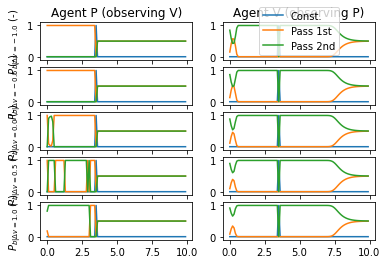

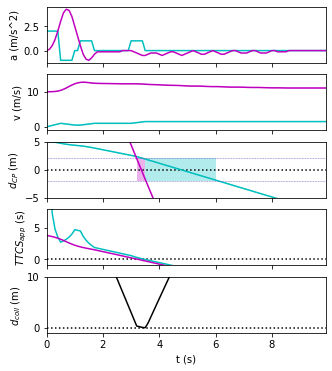

In [6]:
import sc_scenario_helper
sc_scenario_helper.NEW_ACC_IMPL_CALCS = False

print('Base model (with old access order implication calculations):')
optional_assumptions = sc_scenario.get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN)
run_baseline_kinematics(dist0s = (40,))
run_oBEo_etc_seq()